In [1]:
from os import path
import math
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from utils import *
from ipywidgets import interact

# Step 1: Fingerprint segmentation

,,
,,

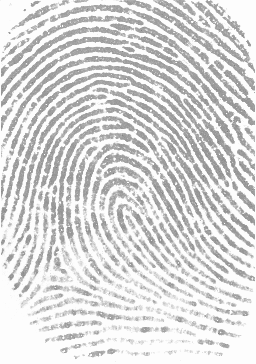
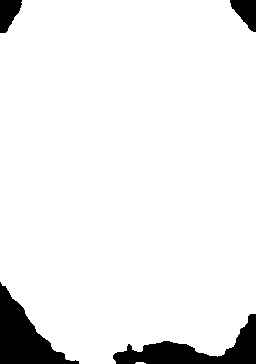
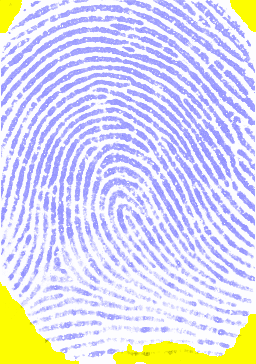

In [2]:
# first of all we read a fingerprint image
fingerprint = cv.imread('fingerprint_sample.png', cv.IMREAD_GRAYSCALE)

# calculate the local gradient (using Sobel filters)
gx, gy = cv.Sobel(fingerprint, cv.CV_32F, 1, 0), cv.Sobel(fingerprint, cv.CV_32F, 0, 1)

# calculate the magnitude of the gradient for each pixel
gx2, gy2 = gx**2, gy**2
gm = np.sqrt(gx2 + gy2)

# integral over a square window
sum_gm = cv.boxFilter(gm, -1, (25, 25), normalize = False)

# use a simple threshold for segmenting the fingerprint pattern
thr = sum_gm.max() * 0.2
mask = cv.threshold(sum_gm, thr, 255, cv.THRESH_BINARY)[1].astype(np.uint8)

show(fingerprint, mask, cv.merge((mask, fingerprint, fingerprint)))

# Step 2: Estimation of local ridge orientation

Orientation image
""

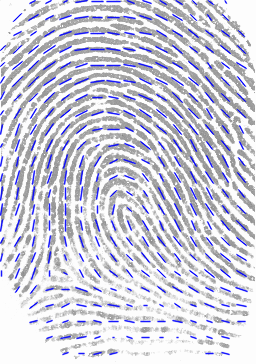

In [3]:
# for each pixel, we will estimate the local orientation from the gradient [Gx,Gy], which we already computed in the previous step.  
# the ridge orientation is estimated as ortoghonal to the gradient orientation, averaged over a window W.
  
W = (16, 16)
gxx = cv.boxFilter(gx2, -1, W, normalize = False)
gyy = cv.boxFilter(gy2, -1, W, normalize = False)
gxy = cv.boxFilter(gx * gy, -1, W, normalize = False)
gxx_gyy = gxx - gyy
gxy2 = 2 * gxy

# For each orientation, we will also calculate a confidence value (strength), which measures how much all gradients in in W share the same orientation.  
orientations = (cv.phase(gxx_gyy, -gxy2) + np.pi) / 2 # '-' to adjust for y axis direction
sum_gxx_gyy = gxx + gyy
strengths = np.divide(cv.sqrt((gxx_gyy**2 + gxy2**2)), sum_gxx_gyy, out=np.zeros_like(gxx), where=sum_gxx_gyy!=0)

show(draw_orientations(fingerprint, orientations, strengths, mask, 1, 16), 'Orientation image')

# Source: A.M. Bazen and S.H. Gerez, "Systematic methods for the computation of the directional fields and singular points of fingerprints," in IEEE tPAMI, July 2002


## Step 3: Estimation of Local Ridge Frequency

In [4]:
region = fingerprint[10:90,80:130]

# before computing the x-signature, the region is smoothed to reduce noise
smoothed = cv.blur(region, (5,5), -1)

# the x-signature is computed from the region and the ridge-line period is estimated as the average number of pixels between two consecutive peaks.
xs = np.sum(smoothed, 1)

# find the indices of the x-signature local maxima
local_maxima = np.nonzero(np.r_[False, xs[1:] > xs[:-1]] & np.r_[xs[:-1] >= xs[1:], False])[0]

# calculate all the distances between consecutive peaks
distances = local_maxima[1:] - local_maxima[:-1]

# estimate the ridge line period as the average of the above distances
ridge_period = np.average(distances)
print(ridge_period)


# Source: L. Hong, Y. Wan and A. Jain, "Fingerprint image enhancement: algorithm and performance evaluation," in IEEE tPAMI, Aug. 1998


9.428571428571429


## Step 4: Fingerprint Enhancement

,
,

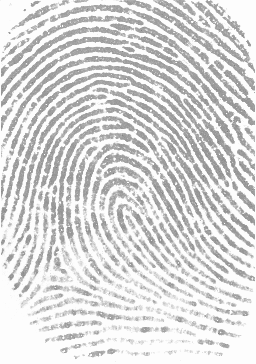
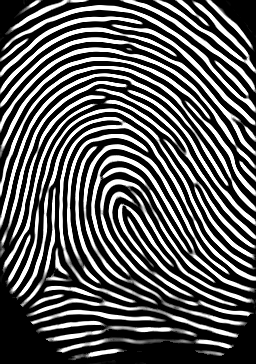

In [5]:
# create the filter bank of 24 filters
or_count = 24
gabor_bank = [gabor_kernel(ridge_period, o) for o in np.arange(0, np.pi, np.pi/or_count)]

# filter the whole image with each filter
# note that the negative image is actually used, to have white ridges on a black
nf = 255-fingerprint
all_filtered = np.array([cv.filter2D(nf, cv.CV_32F, f) for f in gabor_bank])

y_coords, x_coords = np.indices(fingerprint.shape)

# for each pixel, find the index of the closest orientation in the gabor bank
orientation_idx = np.round(((orientations % np.pi) / np.pi) * or_count).astype(np.int32) % or_count

# take the corresponding convolution result for each pixel, to gather the final result
filtered = all_filtered[orientation_idx, y_coords, x_coords]

# convert to gray scale and apply the mask
enhanced = mask & np.clip(filtered, 0, 255).astype(np.uint8)

show(fingerprint, enhanced)

## Sources:

Cuevas, M. (2019, August 5). Fingerprint algorithm recognition. Medium. Retrieved May 17, 2022, from https://medium.com/@cuevas1208/fingerprint-algorithm-recognition-fd2ac0c6f5fc 

Fingerprint. 2021WSB-day2-4: Raffaele Professor demonstrates a fingerprint recognition system (including code) Part 1 with OpenCV and Python - Programmer Sought. (n.d.). Retrieved May 17, 2022, from https://programmersought.com/article/62168225282/#_78v 

DongChengdongHangZhou. (n.d.). Dongchengdonghangzhou/Fingerprint-cropping-binary: 裁剪指纹，二值化指纹. GitHub. Retrieved May 17, 2022, from https://github.com/DongChengdongHangZhou/fingerprint-cropping-binary.git 

Fingerprint. 2021WSB-day2-4: Raffaele Professor Demonstrates a fingerprint recognition system (including code) PART3 with OpenCV and Python - Programmer Sought. (n.d.). Retrieved May 17, 2022, from https://www.programmersought.com/article/79118329411/ 

Turroni, F. (2012). Fingerprint Recognition: Enhancement, Feature Extraction and Automatic Evaluation of Algorithms.

A.M. Bazen and S.H. Gerez, "Systematic methods for the computation of the directional fields and singular points of fingerprints," in IEEE tPAMI, July 2002

L. Hong, Y. Wan and A. Jain, "Fingerprint image enhancement: algorithm and performance evaluation," in IEEE tPAMI, Aug. 1998



